# Module

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import logging

RANDOM_SEED = 42
save_data_path = "./results"
os.makedirs(save_data_path, exist_ok=True)

# class

In [2]:
class data_loader:
    def __init__(self, X_path, sample_annotation_file):
        super().__init__()
        
        self.target_label_name = 'Population code'
        self.notusing_lables = ['IBS,MSL']
        data_split = [0.6, 0.2, 0.2]  # train, val, test

        self.X = np.load(X_path)
        self.sample_annotation_df = pd.read_csv(sample_annotation_file, sep='\t')
        self.y = self.sample_annotation_df[self.target_label_name]
        logging.info(f"[progress] Read data done. X.shape: {self.X.shape}, y.shape: {self.y.shape}")

        self.drop_notusing_sample(notusing_list=self.notusing_lables)
        self.y_encoded, self.label_mapping = self.encode_y()
        self.train_indices, self.val_indices, self.test_indices = self.split_dataset(val_size=data_split[1], test_size=data_split[2])

        logging.info(f" - Data_split: train_set (n={len(self.train_indices)}), val_set (n={len(self.val_indices)}), test_set (n={len(self.test_indices)})")
        assert self.X.shape[0] == self.y.shape[0]
        assert self.X.shape[0] == self.y_encoded.shape[0]
        assert self.test_index_coverage(self.train_indices, self.val_indices, self.test_indices, self.X.shape[0])

    def test_index_coverage(self, train_indices, val_indices, test_indices, total_length):
        combined_indices = np.concatenate((train_indices, val_indices, test_indices))
        unique_indices = np.unique(combined_indices)
        expected_indices = np.arange(total_length)
        if np.array_equal(np.sort(unique_indices), expected_indices):
            return True
        else:
            missing_indices = np.setdiff1d(expected_indices, unique_indices)
            extra_indices = np.setdiff1d(unique_indices, expected_indices)
            print(f"Missing indices: {missing_indices}")
            print(f"Extra indices: {extra_indices}")
            return False

    def drop_notusing_sample(self, notusing_list):
        indices_to_drop = self.sample_annotation_df[self.sample_annotation_df[self.target_label_name].isin(notusing_list)].index
        if not indices_to_drop.empty:
            self.sample_annotation_df = self.sample_annotation_df.drop(indices_to_drop)
            self.y = self.y.drop(indices_to_drop)
            self.X = np.delete(self.X, indices_to_drop, axis=0)
        logging.info(f"[progress] Dropped {len(indices_to_drop)} samples from the dataset. X.shape: {self.X.shape}, y.shape: {self.y.shape}")

    def encode_y(self):
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(self.y)
        label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
        return y_encoded, label_mapping

    def split_dataset(self, val_size=0.15, test_size=0.15):
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=RANDOM_SEED)
        train_val_idx, test_indices = next(sss.split(self.X, self.y_encoded))
        adjusted_val_size = val_size / (1 - test_size)
        sss_val = StratifiedShuffleSplit(n_splits=1, test_size=adjusted_val_size, random_state=RANDOM_SEED)
        train_idx, val_idx = next(sss_val.split(self.X[train_val_idx], self.y_encoded[train_val_idx]))
        train_indices = train_val_idx[train_idx]
        val_indices = train_val_idx[val_idx]
        return train_indices, val_indices, test_indices

    def get_data(self):
        return (self.X, np.array(self.y), self.y_encoded), (self.train_indices, self.val_indices, self.test_indices), self.label_mapping


# data load

In [3]:
feature_data_path = '/project/datacamp/team11/data' 
target_feature = "preprocessed/merged_support3_variance_0.1_random_1M"
# target_feature = "preprocessed/merged_random_1k" 
target_feature_suffix = "_matrix.npy"
sample_annotation_file = os.path.join(feature_data_path, "igsr-1000 genomes 30x on grch38.tsv")

dataset = data_loader(os.path.join(feature_data_path, target_feature + target_feature_suffix), 
                      sample_annotation_file)
(X, y_original, y_encoded), (train_indices, val_indices, test_indices), label_mapping = dataset.get_data()


# Data_split

In [4]:
X_train, X_val, X_test = X[train_indices], X[val_indices], X[test_indices]
y_train, y_val, y_test = y_encoded[train_indices], y_encoded[val_indices], y_encoded[test_indices]
y_labels_train, y_labels_val, y_labels_test = y_original[train_indices], y_original[val_indices], y_original[test_indices]


# train model

In [5]:
def train_ML(X_train, y_train, X_val, y_val, X_test, params, method="SVM"):
    if method == "SVM":
        model = SVC(random_state=42)
        grid_search = GridSearchCV(estimator=model, param_grid=params, cv=3, scoring='accuracy', verbose=1, return_train_score=True)
        grid_search.fit(X_train, y_train)
        model = grid_search.best_estimator_
        y_pred_train = model.predict(X_train)
        y_pred_val = model.predict(X_val)
        y_pred_test = model.predict(X_test)
        return y_pred_train, y_pred_val, y_pred_test, model, grid_search.cv_results_
    else:
        raise ValueError(f"Unsupported method: {method}")

params = {'C': [0.1], 'kernel': ['linear']}
y_pred_train, y_pred_val, y_pred_test, model, cv_results = train_ML(X_train, y_train, X_val, y_val, X_test, params, method="SVM")


Fitting 3 folds for each of 1 candidates, totalling 3 fits


# result

## colors

In [6]:
colors = ['#F8B195', '#F67280', '#C06C84', '#6C5B7B', '#355C7D', '#99B898']

In [23]:
# 글자 크기 조정

## acc_barplot_with_errorbar

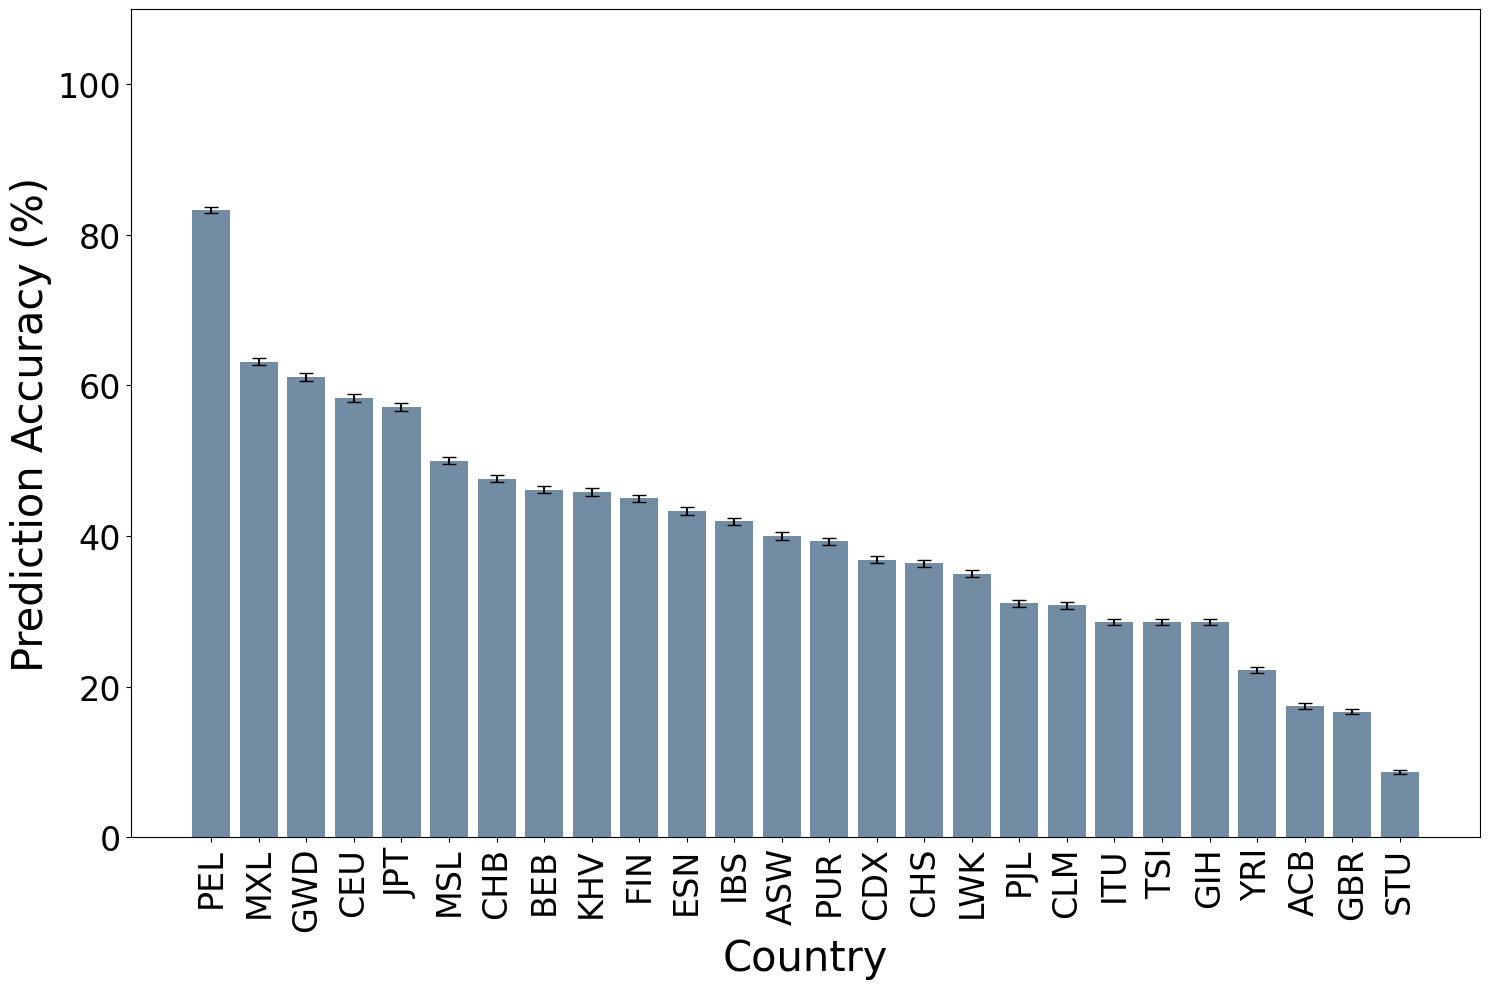

In [16]:
unique_countries = np.unique(y_labels_test)
country_data_count = []
country_accuracies = []
country_sems = []

for country in unique_countries:
    country_indices = np.where(y_labels_test == country)[0]
    y_country = y_test[country_indices]
    y_pred_country = y_pred_test[country_indices]

    country_data_count.append(len(country_indices))

    if len(y_country) > 0:
        accuracy = accuracy_score(y_country, y_pred_country) * 100
        country_accuracies.append(accuracy)
        
        differences = np.array(y_country) != np.array(y_pred_country)
        error_rate = np.mean(differences)
        std_dev = np.sqrt(error_rate * (1 - error_rate) * len(y_country))
        sem = std_dev / np.sqrt(len(y_country))

        country_sems.append(sem)
    else:
        country_accuracies.append(np.nan)
        country_sems.append(np.nan)

df = pd.DataFrame({
    'Country': unique_countries,
    'Data Count': country_data_count,
    'Accuracy': country_accuracies,
    'SEM': country_sems
}).dropna().sort_values(by='Accuracy', ascending=False)

sorted_countries = df['Country'].values
sorted_data_count = df['Data Count'].values
sorted_accuracies = df['Accuracy'].values
sorted_sems = df['SEM'].values

def plot_country_data_with_error_bars(sorted_countries, accuracies, sem, file_path=None):
    fig, ax1 = plt.subplots(figsize=(15, 10))

    ax1.set_xlabel('Country', fontsize=30)
    ax1.set_ylabel('Prediction Accuracy (%)', fontsize=30)
    bars = ax1.bar(sorted_countries, accuracies, yerr=sem, color=colors[4], alpha=0.7, label='Prediction Accuracy', capsize=5)
    
    ax1.tick_params(axis='y')
    ax1.set_ylim(0, 110)
    
    plt.xticks(range(len(sorted_countries)),sorted_countries, rotation=90, fontsize=24)
    plt.yticks(fontsize=24)
    fig.tight_layout()
    

    if file_path:
            plt.savefig(file_path, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

# plot_country_data_with_error_bars(sorted_countries, sorted_accuracies, sorted_sems)#, file_path="test_barplot.pdf")
plot_country_data_with_error_bars(sorted_countries, sorted_accuracies, sorted_sems, file_path="result_barplot.pdf")

## Confusion_matrix_Heatmap

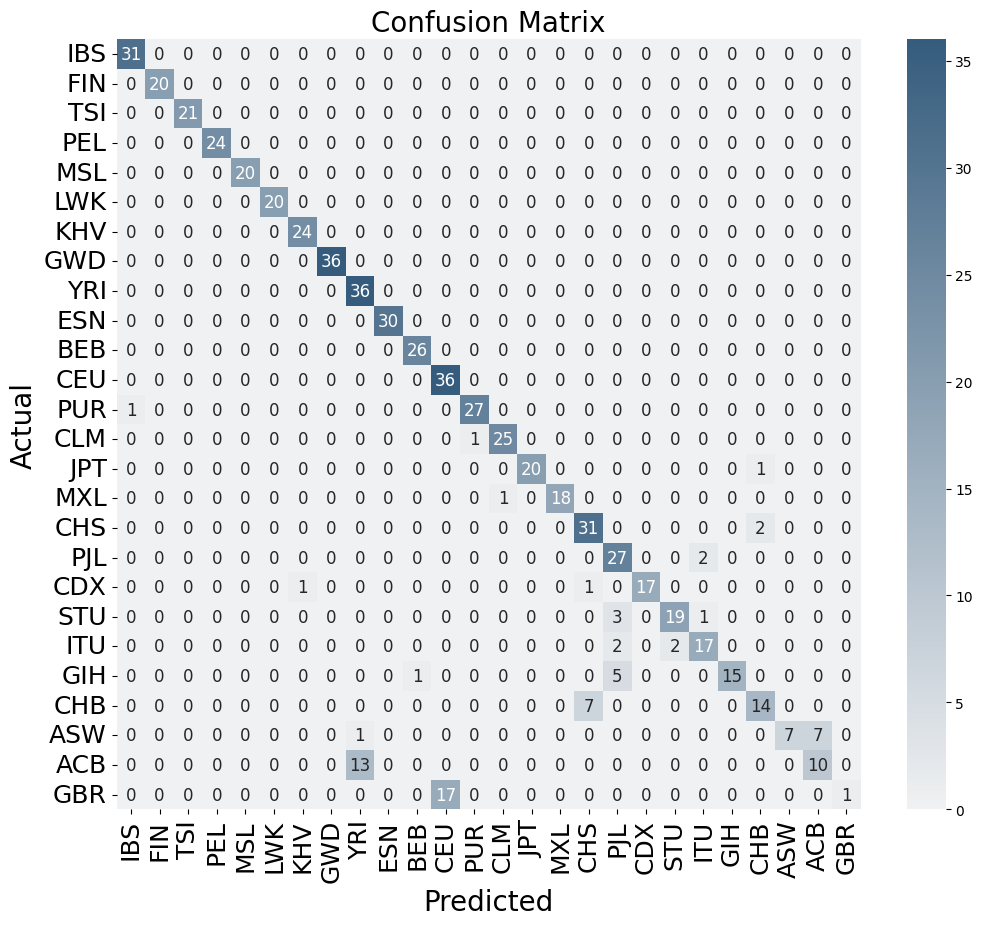

In [10]:
def plot_confusion_matrix(y_true, y_pred, label_mapping, sorted_countries, file_path=None):
    unique_labels = [list(label_mapping.keys())[list(label_mapping.values()).index(country)] for country in sorted_countries]

    conf_matrix = confusion_matrix(y_true, y_pred, labels=unique_labels)

    plt.figure(figsize=(12, 10))
    cmap = sns.light_palette(colors[4], as_cmap=True)
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=sorted_countries, yticklabels=sorted_countries, cmap=cmap, annot_kws={"size": 12})
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actual', fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.title('Confusion Matrix', fontsize=20)

    if file_path:
            plt.savefig(file_path, format='pdf', dpi=300, bbox_inches='tight')
    plt.show()

# plot_confusion_matrix(y_test, y_pred_test, label_mapping, sorted_countries, file_path="test_confusion_matrix.pdf")
plot_confusion_matrix(y_test, y_pred_test, label_mapping, sorted_countries, file_path="result_confusion_matrix.pdf")